# <font color='#11a642' size='6'> **Импорт и установка библиотек**

In [101]:
!pip install category_encoders -q

In [102]:
!pip install shap -q

In [103]:
#from google.colab import drive

In [104]:
import zipfile
import json
import random
import pandas as pd
pd.set_option("display.max_columns", 100)
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder



from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# import category_encoders as ce
from category_encoders.basen import BaseNEncoder
from category_encoders import TargetEncoder

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score

from sklearn.inspection import permutation_importance
import shap

import seaborn as sns
import matplotlib.pyplot as plt


In [105]:
from category_encoders import TargetEncoder

In [106]:
def calculate_metrics_and_plot_roc_comparison(
    model,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    best_threshold: float
) -> dict:
    """
    Рассчитывает метрики классификации и строит ROC-кривые для train и test выборок на одном графике.

    Параметры:
    ----------
    model :
        Обученная модель, реализующая метод predict_proba.

    X_train : np.ndarray
        Признаки обучающей выборки.

    y_train : np.ndarray
        Истинные метки классов обучающей выборки.

    X_test : np.ndarray
        Признаки тестовой выборки.

    y_test : np.ndarray
        Истинные метки классов тестовой выборки.

    best_threshold: float
      Порог для бинарного прогноза.

    Возвращает:
    -----------
    metrics : dict
        Словарь с метриками для обеих выборок.
    """
    results = {}

    for X, y, sample_type in [(X_train, y_train, "train"), (X_test, y_test, "test")]:
        # Предсказание вероятностей
        y_proba = model.predict_proba(X)[:, 1]

        # Прогноз с учетом порога
        y_pred = (y_proba >= 0.5).astype(int)

        # Вычисление метрик
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_proba)
        fpr, tpr, _ = roc_curve(y, y_proba)

        # Сохранение результатов
        results[sample_type] = {
            'precision': precision,
            'recall': recall,
            'roc_auc': roc_auc,
            'fpr': fpr,
            'tpr': tpr,
            'threshold': best_threshold
        }


    # Построение ROC-кривых на одном графике
    plt.figure(figsize=(10, 8))

    colors = {'train': 'blue', 'test': 'red'}
    for sample_type in ['train', 'test']:
        plt.plot(
            results[sample_type]['fpr'],
            results[sample_type]['tpr'],
            color=colors[sample_type],
            lw=2,
            label=f'{sample_type.capitalize()} (AUC = {results[sample_type]["roc_auc"]:.2f})'
        )

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves Comparison ({type(model).__name__})', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

    return results

# <font color='#11a642' size='6'> **Загрузка данных**

In [107]:
def load_dataset(from_kaggle:bool = False) -> pd.DataFrame:
  '''
  Функция скачивает данные с сайта kaggle, если установлен from_kaggle=True,
  инчае архив считывается по ссылке с гугл диска (такой способ удобен тем, у кого нет доступа к kaggle)
  params:
      - from_kaggle - индикатор откуда скачивать данные (True - c сайта kaggle, False -  c google диска)
  return:
      - pd.DataFrame

  '''
  '''
  if from_kaggle:
    # запросит разрешение к гугл диску, необходимо дать это разрешение
    drive.mount('/content/drive')
    # установим kaggle
    !pip install kaggle -q
    !mkdir ~/.kaggle
    # копируем kaggle.json (предварительно, необходимо сгенерить токен на
    # сайте kaggle и сохранить к себе на гугл диск) в папку ~/.kaggle/
    !cp "/content/drive/MyDrive/Colab Notebooks/config/kaggle.json" ~/.kaggle/
    !kaggle competitions download -c playground-series-s5e7
    # !kaggle competitions download -c playground-series-s5e3
  else:
    !gdown 1-730JF1IWA5e_ejuXWLmkkzHFvudisdp
  '''
  # распаковка архива
  zip_ref = zipfile.ZipFile('playground-series-s5e7.zip', 'r')
  zip_ref.extractall()
  zip_ref.close()
  df_train = pd.read_csv('train.csv')
  df_test = pd.read_csv('test.csv')
  df_sample_submission = pd.read_csv('sample_submission.csv')
  return df_train, df_test, df_sample_submission

Time_spent_Alone: Количество часов, проводимых в одиночестве ежедневно (0–11).

Stage_fear: Наличие страха сцены (Да/Нет).

Social_event_attendance: Частота посещения социальных мероприятий (0–10).

Going_outside: Частота выхода из дома (0–7).

Drained_after_socializing: Чувство опустошения после общения (Да/Нет).

Friends_circle_size: Количество близких друзей (0–15).

Post_frequency: Частота публикаций в соцсетях (0–10).

Personality: Целевая переменная (Экстраверт/Интроверт).

In [108]:
df_train, df_test, df_sample_submission = load_dataset(from_kaggle = False)

In [109]:
df_train

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
...,...,...,...,...,...,...,...,...,...
18519,18519,3.0,No,7.0,3.0,No,9.0,7.0,Extrovert
18520,18520,1.0,NaN,6.0,7.0,No,6.0,5.0,Extrovert
18521,18521,7.0,Yes,1.0,1.0,Yes,1.0,NaN,Introvert
18522,18522,NaN,Yes,1.0,0.0,Yes,5.0,2.0,Introvert


In [110]:
df_train.columns = (col.lower().replace("(", "_").replace(")", "").replace(" ", "_") for col in df_train.columns)


In [111]:
df_train.head()

,id,time_spent_alone,stage_fear,social_event_attendance,going_outside,drained_after_socializing,friends_circle_size,post_frequency,personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [112]:
df_test.columns = (col.lower().replace("(", "_").replace(")", "").replace(" ", "_") for col in df_test.columns)


In [113]:
df_train['personality'].unique()

array(['Extrovert', 'Introvert'], dtype=object)

In [114]:
dict_personality = {'Extrovert':0, 'Introvert':1}
df_train['int_personality'] = df_train['personality'].map(dict_personality)

In [115]:
df_train.shape

(18524, 10)

Time_spent_Alone: Количество часов, проводимых в одиночестве ежедневно (0–11).

Stage_fear: Наличие страха сцены (Да/Нет).

Social_event_attendance: Частота посещения социальных мероприятий (0–10).

Going_outside: Частота выхода из дома (0–7).

Drained_after_socializing: Чувство опустошения после общения (Да/Нет).

Friends_circle_size: Количество близких друзей (0–15).

Post_frequency: Частота публикаций в соцсетях (0–10).

Personality: Целевая переменная (Экстраверт/Интроверт).

In [116]:
df_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,18524.0,NaN,NaN,NaN,9261.5,5347.562529,0.0,4630.75,9261.5,13892.25,18523.0
time_spent_alone,17334.0,NaN,NaN,NaN,3.137764,3.003786,0.0,1.0,2.0,4.0,11.0
stage_fear,16631,2,No,12609,NaN,NaN,NaN,NaN,NaN,NaN,NaN
social_event_attendance,17344.0,NaN,NaN,NaN,5.265106,2.753359,0.0,3.0,5.0,8.0,10.0
going_outside,17058.0,NaN,NaN,NaN,4.044319,2.06258,0.0,3.0,4.0,6.0,7.0
drained_after_socializing,17375,2,No,13313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
friends_circle_size,17470.0,NaN,NaN,NaN,7.996737,4.223484,0.0,5.0,8.0,12.0,15.0
post_frequency,17260.0,NaN,NaN,NaN,4.982097,2.879139,0.0,3.0,5.0,7.0,10.0
personality,18524,2,Extrovert,13699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_personality,18524.0,NaN,NaN,NaN,0.260473,0.438905,0.0,0.0,0.0,1.0,1.0


In [117]:
df_train['time_spent_alone'].value_counts(normalize=True, dropna=False)

time_spent_alone
0.0     0.169456
3.0     0.166325
2.0     0.164057
1.0     0.160494
NaN     0.064241
4.0     0.058249
5.0     0.034172
10.0    0.031689
8.0     0.031419
7.0     0.031365
6.0     0.030987
9.0     0.030987
11.0    0.026560
Name: proportion, dtype: float64

In [118]:
df_train['drained_after_socializing'].value_counts(normalize=True, dropna=False)

drained_after_socializing
No     0.718689
Yes    0.219283
NaN    0.062028
Name: proportion, dtype: float64

In [119]:
df_train['stage_fear'].value_counts(normalize=True, dropna=False)

stage_fear
No     0.680685
Yes    0.217124
NaN    0.102192
Name: proportion, dtype: float64

In [120]:
df_train['drained_after_socializing'].value_counts(normalize=True, dropna=False)

drained_after_socializing
No     0.718689
Yes    0.219283
NaN    0.062028
Name: proportion, dtype: float64

In [121]:
df_train['social_event_attendance'].value_counts(normalize=True, dropna=False)

social_event_attendance
4.0     0.111909
9.0     0.111369
7.0     0.109642
5.0     0.107158
6.0     0.107104
8.0     0.104999
3.0     0.091935
NaN     0.063701
2.0     0.057385
0.0     0.056953
1.0     0.052796
10.0    0.025049
Name: proportion, dtype: float64

> social_event_attendance -> 0

In [122]:
df_train['friends_circle_size'].isna().mean()

0.05689915784927661

> friends_circle_size -> mean

> точка улучшения: можно заменить моделью




In [123]:
df_train.groupby('personality')['friends_circle_size'].mean()

personality
Extrovert    9.624587
Introvert    3.263923
Name: friends_circle_size, dtype: float64

In [124]:
df_train['post_frequency'].isna().mean()

0.06823580220254805

In [125]:
df_train[pd.isna(df_train['post_frequency'])].isna().sum()


id                              0
time_spent_alone               52
stage_fear                     46
social_event_attendance        42
going_outside                  54
drained_after_socializing      31
friends_circle_size            48
post_frequency               1264
personality                     0
int_personality                 0
dtype: int64

In [126]:
df_train.isna().sum()

id                              0
time_spent_alone             1190
stage_fear                   1893
social_event_attendance      1180
going_outside                1466
drained_after_socializing    1149
friends_circle_size          1054
post_frequency               1264
personality                     0
int_personality                 0
dtype: int64

<Axes: >

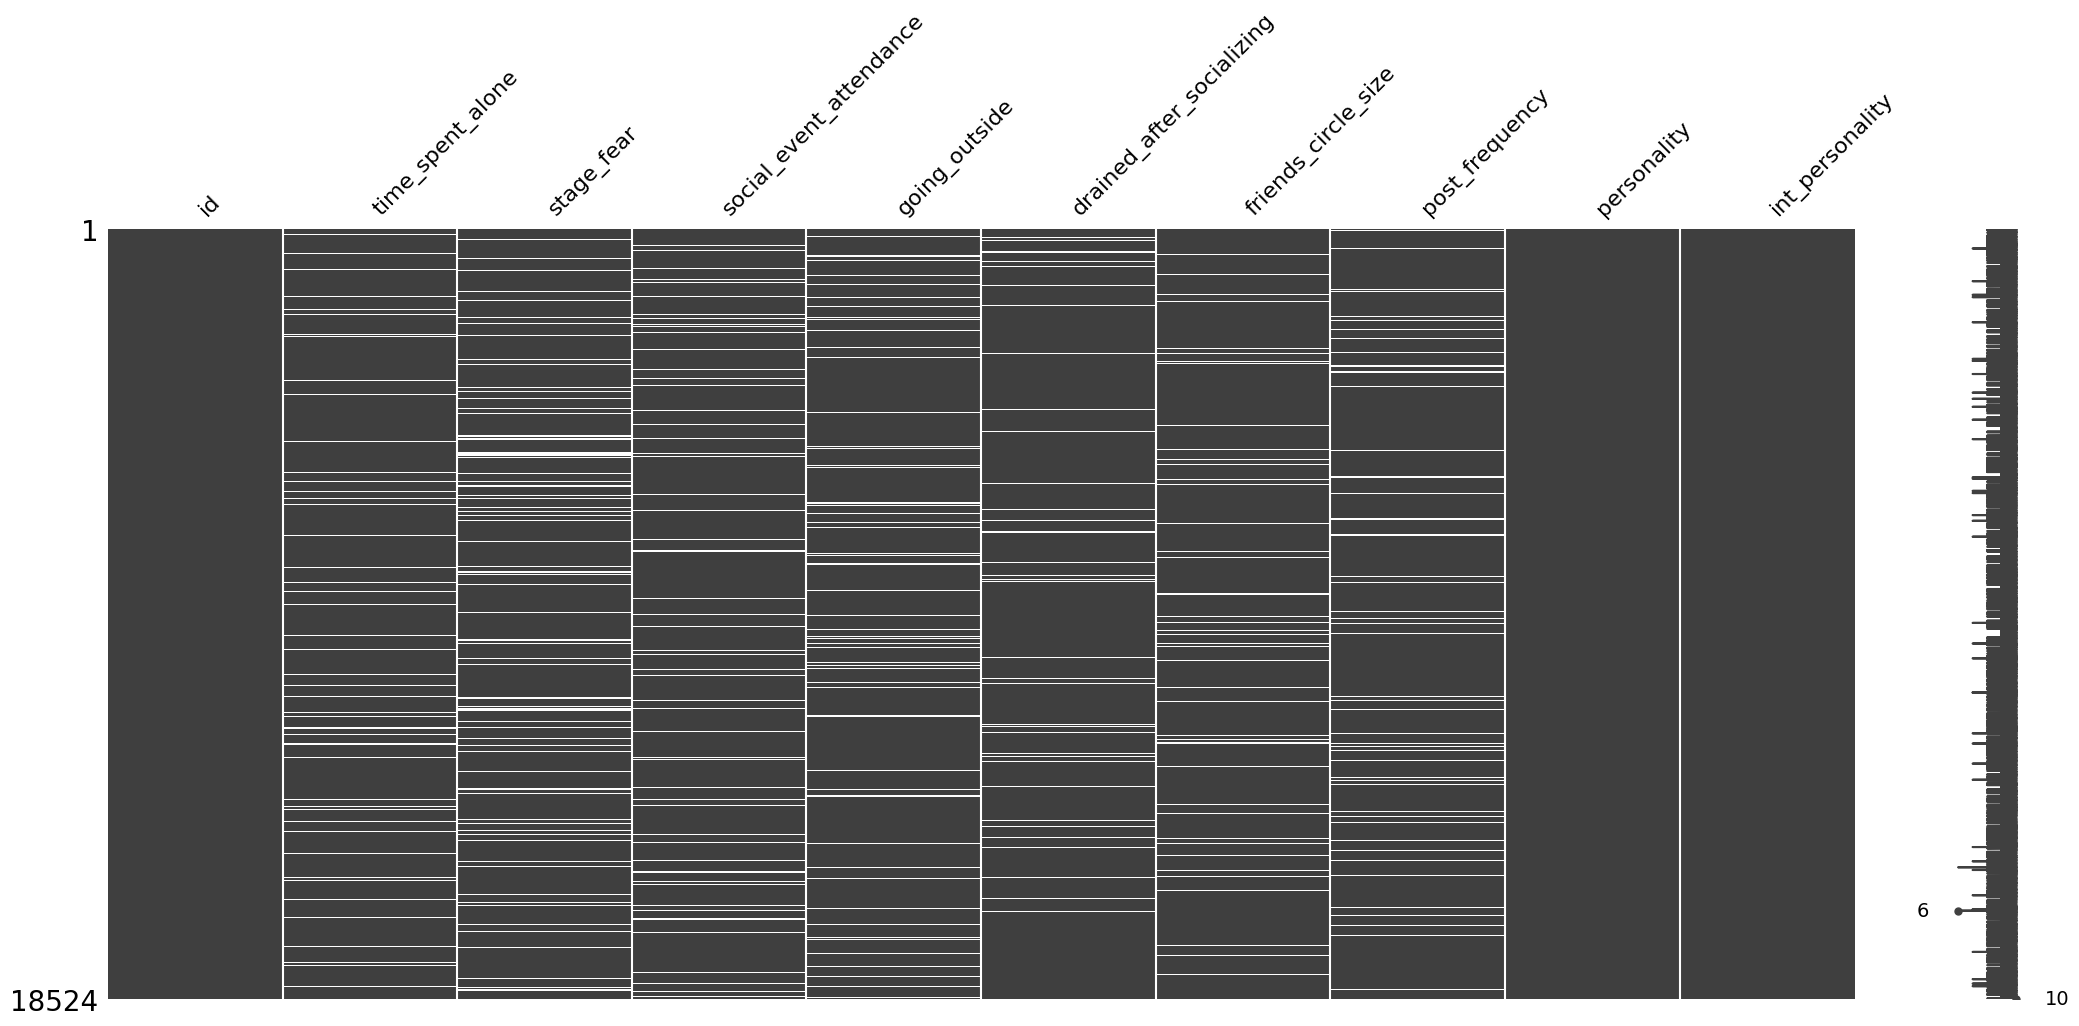

In [127]:
import missingno as msno
msno.matrix(df_train)


In [128]:
#df_train = df.copy()

## <font color='#11a642' size='5'> Определить роли для независимых признаков

In [129]:
id_features = ['id', ]
target = 'int_personality'
exclude_features = ['personality',]

num_features = [col for col in df_train.select_dtypes(include='number').columns
                if col not in id_features + [target, ] + exclude_features]

cat_features = [col for col in df_train.select_dtypes(exclude='number').columns
                if col not in id_features + [target, ] + exclude_features]


In [130]:
num_features

['time_spent_alone',
 'social_event_attendance',
 'going_outside',
 'friends_circle_size',
 'post_frequency']

In [131]:
cat_features

['stage_fear', 'drained_after_socializing']

# <font color='#11a642' size='6'> **Разведочный анализ данных**

In [132]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   time_spent_alone           17334 non-null  float64
 2   stage_fear                 16631 non-null  object 
 3   social_event_attendance    17344 non-null  float64
 4   going_outside              17058 non-null  float64
 5   drained_after_socializing  17375 non-null  object 
 6   friends_circle_size        17470 non-null  float64
 7   post_frequency             17260 non-null  float64
 8   personality                18524 non-null  object 
 9   int_personality            18524 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 1.4+ MB


In [133]:
df_train.isna().sum()[df_train.isna().sum()>0]

time_spent_alone             1190
stage_fear                   1893
social_event_attendance      1180
going_outside                1466
drained_after_socializing    1149
friends_circle_size          1054
post_frequency               1264
dtype: int64

In [134]:
df_train

,id,time_spent_alone,stage_fear,social_event_attendance,going_outside,drained_after_socializing,friends_circle_size,post_frequency,personality,int_personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert,0
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert,0
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert,1
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert,0
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert,0
...,...,...,...,...,...,...,...,...,...,...
18519,18519,3.0,No,7.0,3.0,No,9.0,7.0,Extrovert,0
18520,18520,1.0,NaN,6.0,7.0,No,6.0,5.0,Extrovert,0
18521,18521,7.0,Yes,1.0,1.0,Yes,1.0,NaN,Introvert,1
18522,18522,NaN,Yes,1.0,0.0,Yes,5.0,2.0,Introvert,1


<Axes: xlabel='int_personality', ylabel='proportion'>

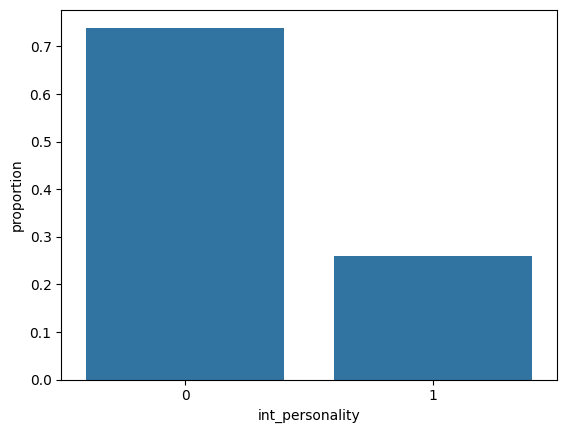

In [135]:
sns.barplot(df_train[target].value_counts(normalize=True))

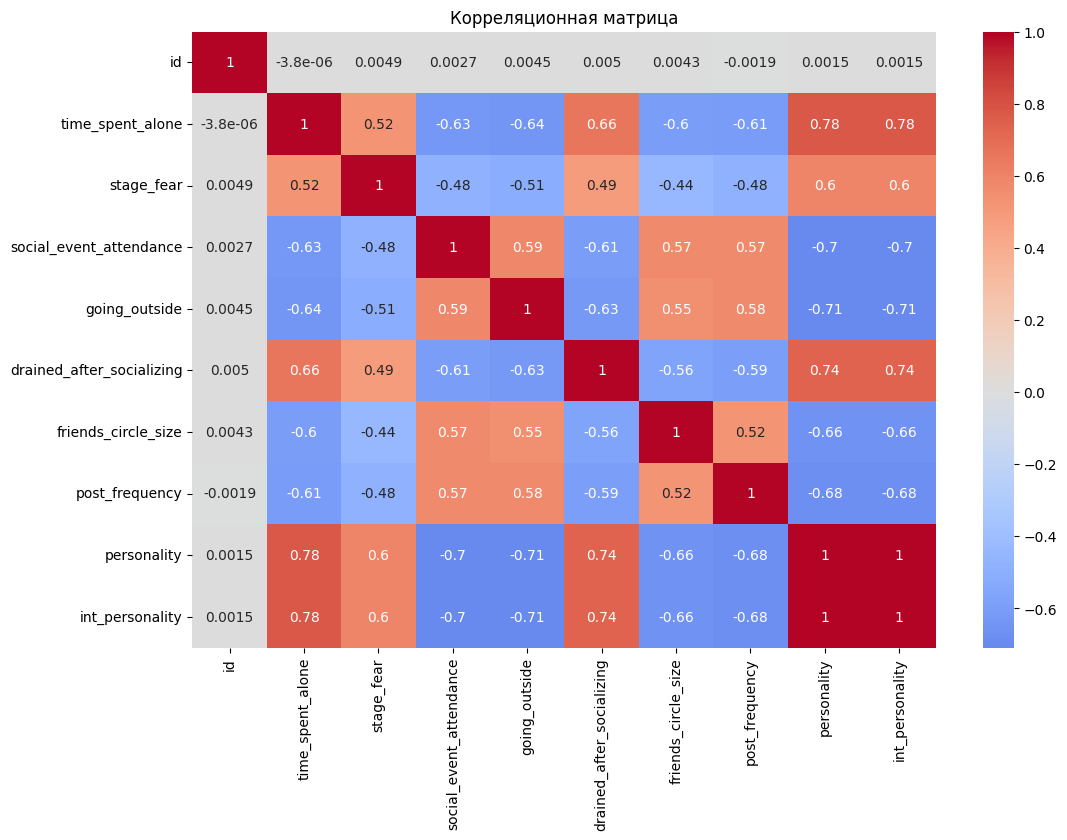

In [136]:
label_encoder = LabelEncoder()
df_encoded = df_train.copy()
df_encoded['stage_fear'] = label_encoder.fit_transform(df_encoded['stage_fear'])
df_encoded['drained_after_socializing'] = label_encoder.fit_transform(df_encoded['drained_after_socializing'])
df_encoded['personality'] = label_encoder.fit_transform(df_encoded['personality'])

plt.figure(figsize=(12, 8))
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица')
plt.show()

# <font color='#11a642' size='6'> **Разделите данные на трейн и тест**

In [137]:
df_train.head()

,id,time_spent_alone,stage_fear,social_event_attendance,going_outside,drained_after_socializing,friends_circle_size,post_frequency,personality,int_personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert,0
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert,0
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert,1
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert,0
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert,0


In [138]:
df_train[num_features + cat_features ].loc[75, :]

time_spent_alone              2.0
social_event_attendance       7.0
going_outside                 5.0
friends_circle_size          10.0
post_frequency                8.0
stage_fear                     No
drained_after_socializing      No
Name: 75, dtype: object

In [139]:
X_train, X_test, y_train, y_test = train_test_split(df_train[num_features + cat_features ],
                                                    df_train[target],
                                                    stratify=df_train[target],
                                                    train_size=0.75,
                                                    random_state=12345)

In [140]:
X_test.head()

,time_spent_alone,social_event_attendance,going_outside,friends_circle_size,post_frequency,stage_fear,drained_after_socializing
7111,0.0,9.0,7.0,11.0,6.0,No,No
2307,0.0,5.0,4.0,4.0,6.0,No,No
2687,1.0,6.0,4.0,6.0,10.0,No,No
8129,NaN,9.0,6.0,9.0,8.0,No,No
14625,3.0,6.0,7.0,7.0,8.0,No,No


In [141]:
X_test.shape , X_train.shape

((4631, 7), (13893, 7))

# <font color='#11a642' size='6'> **Подготовка данных к обучению**

## c pipeline

In [142]:
# SimpleImputer + OHE
cat_pipe = Pipeline(
    [

        (
            'enc',
            TargetEncoder(cols = cat_features)

        ),
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),

    ]
)

In [143]:
# TODO разделить pipeline: некоторые переменные -0 , некоторые среднее (или модель)
# SimpleImputer + StandardScaler
num_pipe = Pipeline(
    [
        (
            'scaler',
            StandardScaler()
        ),
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),

    ]
)

In [144]:
data_preprocessor = ColumnTransformer(
    [
        ('cat', cat_pipe, cat_features),
        ('num', num_pipe, num_features),
    ],
    remainder='passthrough'
)

In [145]:
type(data_preprocessor.fit_transform(X_train, y_train))

numpy.ndarray

In [146]:
data_preprocessor.get_feature_names_out()
data_preprocessor.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('enc',
                                                  TargetEncoder(cols=['stage_fear',
                                                                      'drained_after_socializing'])),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['stage_fear', 'drained_after_socializing']),
                                ('num',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('imputer', SimpleImputer())]),
                                 ['time_spent_alone', 'social_event_attendance',
                                  'going_outside', 'friends_circle_size',
                                  'post_frequency'])])

In [147]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train, y_train),
    columns=data_preprocessor.get_feature_names_out()
)

X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()
)

In [148]:
X_train_p.head()

,cat__stage_fear,cat__drained_after_socializing,num__time_spent_alone,num__social_event_attendance,num__going_outside,num__friends_circle_size,num__post_frequency
12155,0.023180,0.023409,-1.984642e-17,-0.457435,-5.070073e-01,0.710376,3.348346e-03
113,0.023180,0.023409,-1.044524e+00,1.725196,-2.176307e-02,0.236900,1.043854e+00
12080,0.023180,0.023409,-1.044524e+00,1.361424,1.087282e-16,0.710376,3.501834e-01
15830,0.023180,0.023409,-1.984642e-17,1.361424,-2.176307e-02,1.420589,3.501834e-01
6865,0.942353,0.942364,2.624977e+00,-1.548751,-1.477496e+00,-1.183526,7.792483e-17


In [149]:
X_test_p.head()

,cat__stage_fear,cat__drained_after_socializing,num__time_spent_alone,num__social_event_attendance,num__going_outside,num__friends_circle_size,num__post_frequency
7111,0.02318,0.023409,-1.044524e+00,1.361424,1.433970,0.710376,0.350183
2307,0.02318,0.023409,-1.044524e+00,-0.093664,-0.021763,-0.946788,0.350183
2687,0.02318,0.023409,-7.109334e-01,0.270108,-0.021763,-0.473313,1.737524
8129,0.02318,0.023409,-1.984642e-17,1.361424,0.948725,0.236900,1.043854
14625,0.02318,0.023409,-4.375132e-02,0.270108,1.433970,-0.236575,1.043854


# <font color='#11a642' size='6'> **Построение моделей**

## <font color='blue' size='5'> **Логистическая регрессия**

In [150]:
model_log_reg = LogisticRegression()

In [151]:
model_log_reg.fit(X_train_p, y_train)

LogisticRegression()

In [152]:
y_pred_test = model_log_reg.predict_proba(X_test_p)

In [153]:
y_pred_train = model_log_reg.predict_proba(X_train_p)

In [154]:
X_train_p.columns

Index(['cat__stage_fear', 'cat__drained_after_socializing',
       'num__time_spent_alone', 'num__social_event_attendance',
       'num__going_outside', 'num__friends_circle_size',
       'num__post_frequency'],
      dtype='object')

In [155]:
model_log_reg.coef_[0]

array([ 1.89691633,  2.77649956,  0.56312428, -0.30697361, -0.2186083 ,
       -0.32512984, -0.32560818])

In [156]:
feature_imp = pd.DataFrame({'feature': list(X_train_p.columns), 'coef': model_log_reg.coef_[0]} )
feature_imp.sort_values('coef', ascending=False)

,feature,coef
1,cat__drained_after_socializing,2.776500
0,cat__stage_fear,1.896916
2,num__time_spent_alone,0.563124
4,num__going_outside,-0.218608
3,num__social_event_attendance,-0.306974
5,num__friends_circle_size,-0.325130
6,num__post_frequency,-0.325608


<Axes: xlabel='coef', ylabel='feature'>

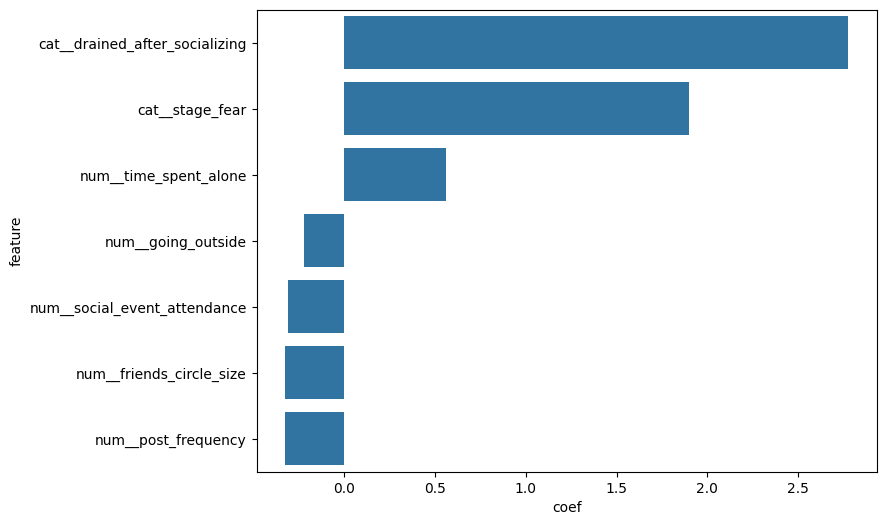

In [157]:
plt.figure(figsize=(8, 6))
sns.barplot(feature_imp.sort_values('coef', ascending=False), y = 'feature', x='coef')

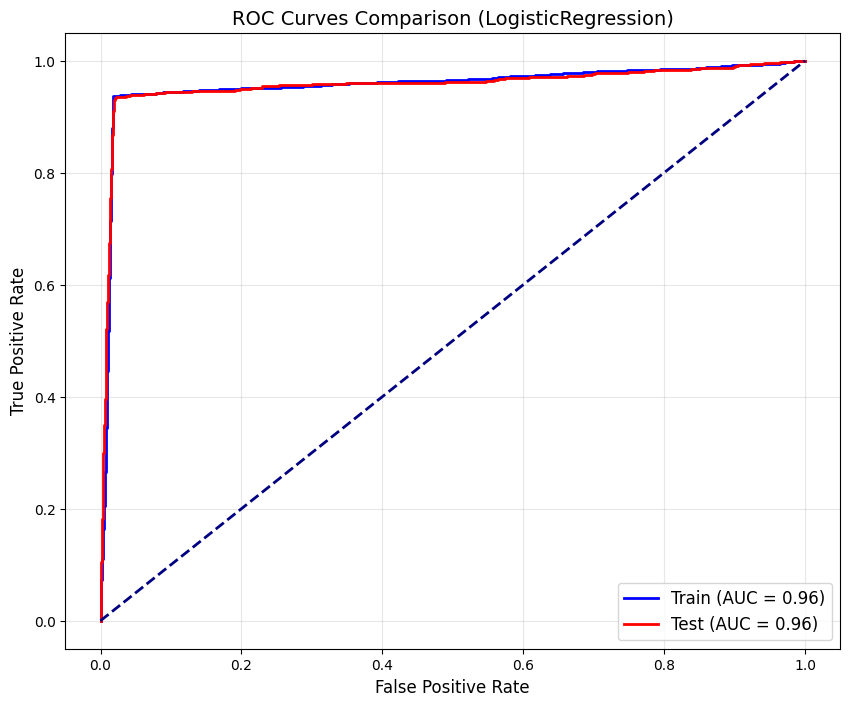

In [158]:
res = calculate_metrics_and_plot_roc_comparison(
    model_log_reg,
    X_train_p,
    y_train,
    X_test_p,
    y_test,
    0.5)

## <font color='blue' size='5'> **Дерево решений**

In [159]:
params = {
    'criterion': ['gini',],
    'max_depth': [5, 10, 15,], # range(3, 15, 3)
    'min_samples_leaf': [10, 15, 20],
    'ccp_alpha': np.arange(0.1, 2, 0.5)
}

In [160]:
tree_classifier = DecisionTreeClassifier(random_state=42)

In [161]:
# Создаем объект GridSearchCV
grid_search = GridSearchCV(estimator=tree_classifier, param_grid=params, cv=5, n_jobs=-1, scoring='accuracy')


In [162]:
grid_search.fit(X_train_p, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.1, 0.6, 1.1, 1.6]),
                         'criterion': ['gini'], 'max_depth': [5, 10, 15],
                         'min_samples_leaf': [10, 15, 20]},
             scoring='accuracy')

In [163]:
grid_search.best_params_

{'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}

In [164]:
best_tree = grid_search.best_estimator_

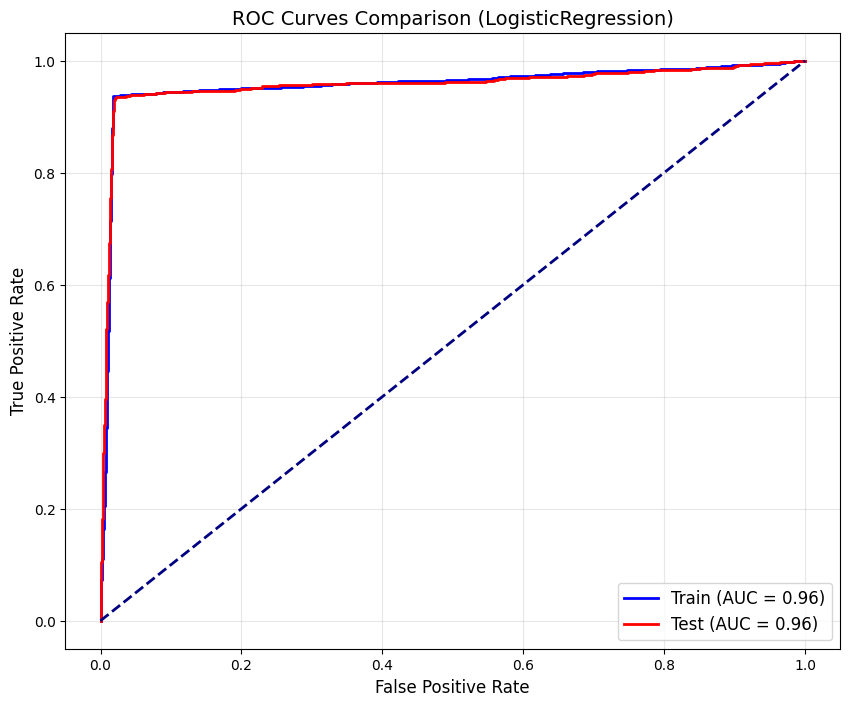

{'train': {'precision': 0.9476337160459255,
  'recall': 0.935064935064935,
  'roc_auc': 0.9577771331340555,
  'fpr': array([0.00000000e+00, 0.00000000e+00, 9.73330738e-05, 9.73330738e-05,
         1.94666148e-04, 1.94666148e-04, 2.91999221e-04, 2.91999221e-04,
         3.89332295e-04, 3.89332295e-04, 4.86665369e-04, 4.86665369e-04,
         5.83998443e-04, 5.83998443e-04, 6.81331516e-04, 6.81331516e-04,
         8.75997664e-04, 8.75997664e-04, 9.73330738e-04, 9.73330738e-04,
         1.07066381e-03, 1.07066381e-03, 1.16799689e-03, 1.16799689e-03,
         1.26532996e-03, 1.26532996e-03, 1.36266303e-03, 1.36266303e-03,
         1.45999611e-03, 1.45999611e-03, 1.55732918e-03, 1.55732918e-03,
         1.65466225e-03, 1.65466225e-03, 1.75199533e-03, 1.75199533e-03,
         1.84932840e-03, 1.84932840e-03, 1.94666148e-03, 1.94666148e-03,
         2.04399455e-03, 2.04399455e-03, 2.14132762e-03, 2.14132762e-03,
         2.23866070e-03, 2.23866070e-03, 2.33599377e-03, 2.33599377e-03,
         

In [165]:
calculate_metrics_and_plot_roc_comparison(
    model_log_reg,
    X_train_p,
    y_train,
    X_test_p,
    y_test,
    0.5)

In [166]:
pred_train = best_tree.predict_proba(X_train_p)
pred_test = best_tree.predict_proba(X_test_p)

In [167]:
pd.DataFrame(
    {"feature": X_train_p.columns, "importance": best_tree.feature_importances_}
).sort_values(by="importance", ascending=False).reset_index(drop=True)

,feature,importance
0,cat__drained_after_socializing,1.0
1,cat__stage_fear,0.0
2,num__time_spent_alone,0.0
3,num__social_event_attendance,0.0
4,num__going_outside,0.0
5,num__friends_circle_size,0.0
6,num__post_frequency,0.0


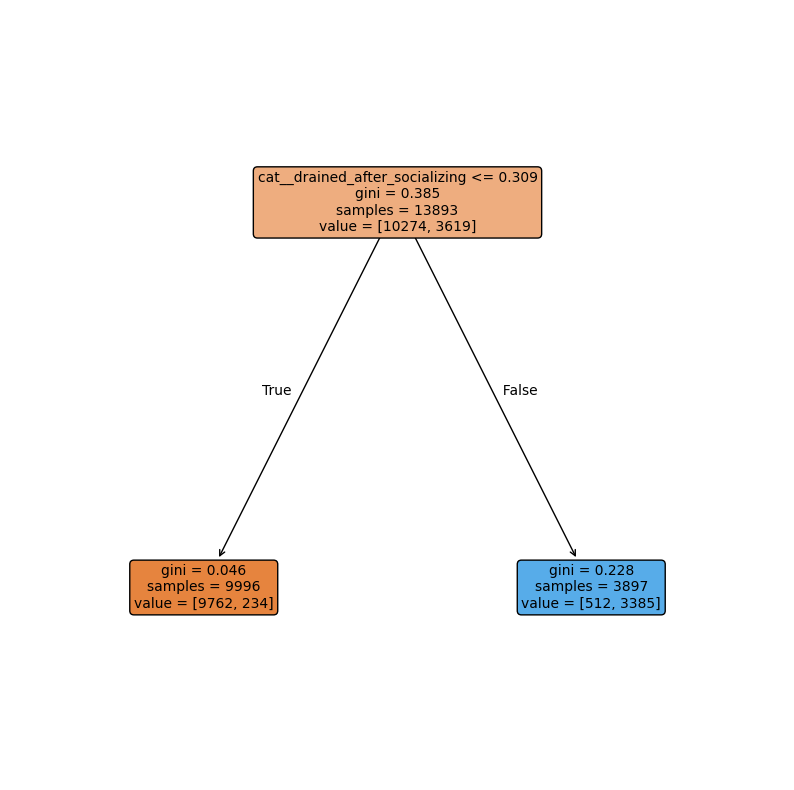

<Figure size 640x480 with 0 Axes>

In [168]:
# второй способ отрисовать деревья с помощью plot_tree
plt.figure(figsize=(10, 10))
plot_tree(best_tree, feature_names=X_train_p.columns, filled=True, rounded=True,  fontsize=10)
plt.show()
plt.savefig('tree.png')

## <font color='blue'> **Random Forest**

In [169]:
# итоговый пайплайн: подготовка данных и модель RandomForestClassifier
rf_cl = Pipeline(
   [
       ('preprocessor', data_preprocessor),
       ('rf_models', RandomForestClassifier(random_state = 47))

   ]
)

In [170]:
rf_cl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('enc',
                                                                   TargetEncoder(cols=['stage_fear',
                                                                                       'drained_after_socializing'])),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['stage_fear',
                                                   'drained_after_socializing']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['time_spent_alone',
                                                   'social_event_attendance',
                                                   'going_outside',
                                                   'friends_circle_size',
                                                   'post_frequency'])])),
                ('rf_models', RandomForestClassifier(random_state=47))])

In [171]:
pred_train = rf_cl.predict_proba(X_train)

In [172]:
pred_test = rf_cl.predict_proba(X_test)

In [173]:
rf_cl.steps

[('preprocessor',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('cat',
                                   Pipeline(steps=[('enc',
                                                    TargetEncoder(cols=['stage_fear',
                                                                        'drained_after_socializing'])),
                                                   ('imputer',
                                                    SimpleImputer(strategy='most_frequent'))]),
                                   ['stage_fear', 'drained_after_socializing']),
                                  ('num',
                                   Pipeline(steps=[('scaler', StandardScaler()),
                                                   ('imputer', SimpleImputer())]),
                                   ['time_spent_alone', 'social_event_attendance',
                                    'going_outside', 'friends_circle_size',
                                    'post

In [174]:
from scipy.stats import randint

param_distributions = {
    'rf_models__n_estimators': randint(50, 400),
    'rf_models__criterion': ['gini'],
    'rf_models__max_depth': randint(3, 15),
    'rf_models__min_samples_split': randint(2, 15),
    'rf_models__min_samples_leaf': randint(1, 15),
    'rf_models__max_features': ['log2', 'sqrt'],
}

In [175]:
random_search = RandomizedSearchCV(
    estimator=rf_cl,
    param_distributions=param_distributions,
    n_iter=100,            # Количество случайных комбинаций (можешь увеличить)
    cv=5,                 # 5-fold CV
    scoring='f1',         # Оценка по F1
    verbose=2,
    n_jobs=-1,            # Используем все ядра
    random_state=42
)

random_search.fit(X_train, y_train)

print("Лучшие параметры:", random_search.best_params_)
print("Лучший F1 на кросс-валидации:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END rf_models__criterion=gini, rf_models__max_depth=9, rf_models__max_features=sqrt, rf_models__min_samples_leaf=13, rf_models__min_samples_split=12, rf_models__n_estimators=121; total time=   1.1s
[CV] END rf_models__criterion=gini, rf_models__max_depth=9, rf_models__max_features=sqrt, rf_models__min_samples_leaf=13, rf_models__min_samples_split=12, rf_models__n_estimators=121; total time=   1.1s
[CV] END rf_models__criterion=gini, rf_models__max_depth=9, rf_models__max_features=sqrt, rf_models__min_samples_leaf=13, rf_models__min_samples_split=12, rf_models__n_estimators=121; total time=   1.1s
[CV] END rf_models__criterion=gini, rf_models__max_depth=9, rf_models__max_features=sqrt, rf_models__min_samples_leaf=13, rf_models__min_samples_split=12, rf_models__n_estimators=121; total time=   1.2s
[CV] END rf_models__criterion=gini, rf_models__max_depth=9, rf_models__max_features=sqrt, rf_models__min_samples_leaf=13, rf_

In [176]:
'''param_grid = {
    'rf_models__n_estimators': [100, 300],  # Количество деревьев в лесу
    'rf_models__criterion': ['gini', ],      # Функция для измерения качества разделения: индекс Джини или энтропия
    'rf_models__max_depth': [5, 7, 10],        # Максимальная глубина дерева: ограничение глубины для избежания переобучения
    'rf_models__min_samples_split': [5, 10],       # Минимальное количество выборок, необходимых для разделения внутреннего узла
    'rf_models__min_samples_leaf': [7, 10],         # Минимальное количество выборок, необходимых для узла листа
    'rf_models__max_features': ['log2'], # Количество признаков для поиска наилучшего разделения
                                                       # 'sqrt' - корень из общего кол-ва признаков, 'log2' - логарифм по основанию 2 от общего кол-ва признаков, None - все признаки
}'''

"param_grid = {\n    'rf_models__n_estimators': [100, 300],  # Количество деревьев в лесу\n    'rf_models__criterion': ['gini', ],      # Функция для измерения качества разделения: индекс Джини или энтропия\n    'rf_models__max_depth': [5, 7, 10],        # Максимальная глубина дерева: ограничение глубины для избежания переобучения\n    'rf_models__min_samples_split': [5, 10],       # Минимальное количество выборок, необходимых для разделения внутреннего узла\n    'rf_models__min_samples_leaf': [7, 10],         # Минимальное количество выборок, необходимых для узла листа\n    'rf_models__max_features': ['log2'], # Количество признаков для поиска наилучшего разделения\n                                                       # 'sqrt' - корень из общего кол-ва признаков, 'log2' - логарифм по основанию 2 от общего кол-ва признаков, None - все признаки\n}"

In [177]:
#grid_search = GridSearchCV(rf_cl, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)


In [178]:
#grid_search.fit(X_train, y_train)

In [179]:
# Получаем лучшее значение параметров, найденных в процессе кросс-валидации
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}


In [180]:
#pred_train = grid_search.best_estimator_.predict_proba(X_train)

In [181]:
#best_rf_model = grid_search.best_estimator_

In [182]:
#pred_test = best_rf_model.predict_proba(X_test)

In [183]:
""" res_rf = calculate_metrics_and_plot_roc_comparison(
    best_rf_model,
    X_train,
    y_train,
    X_test,
    y_test,
    0.5) """

' res_rf = calculate_metrics_and_plot_roc_comparison(\n    best_rf_model,\n    X_train,\n    y_train,\n    X_test,\n    y_test,\n    0.5) '

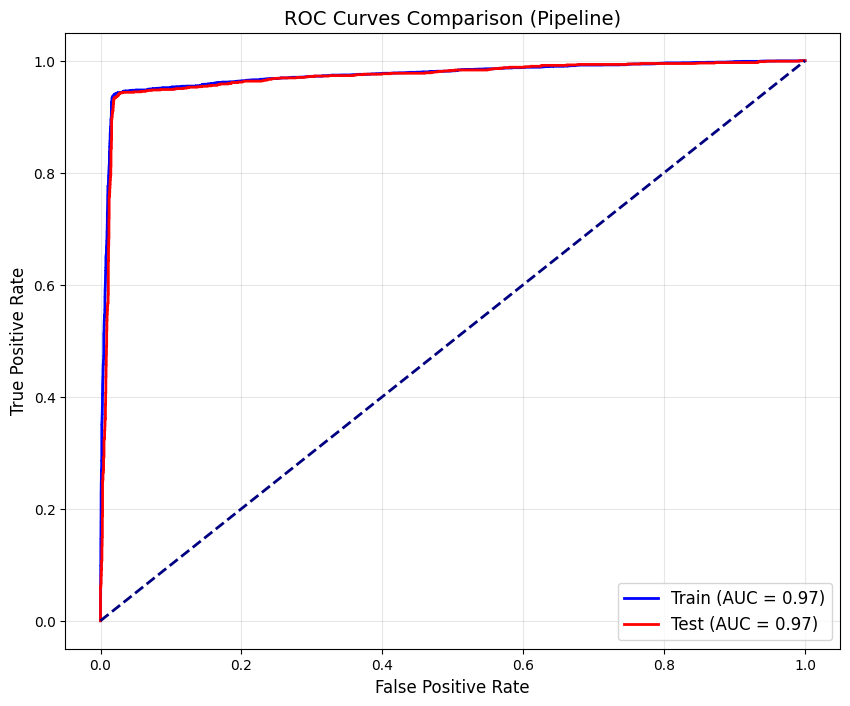

In [184]:
best_rf_model = random_search.best_estimator_

res_rf = calculate_metrics_and_plot_roc_comparison(
    best_rf_model,
    X_train,
    y_train,
    X_test,
    y_test,
    0.5
)

# <font color='blue'> **Интерпретация лучшей модели**

In [185]:
best_rf_model.steps[1][1]

RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=99,
                       random_state=47)

In [186]:
%%time
explainer_tree = shap.Explainer(best_rf_model.steps[1][1].predict, X_test_p)
shap_values_tree = explainer_tree(X_test_p)

ExactExplainer explainer: 4632it [02:37, 27.59it/s]                          

CPU times: user 2min 35s, sys: 2.27 s, total: 2min 37s
Wall time: 2min 37s


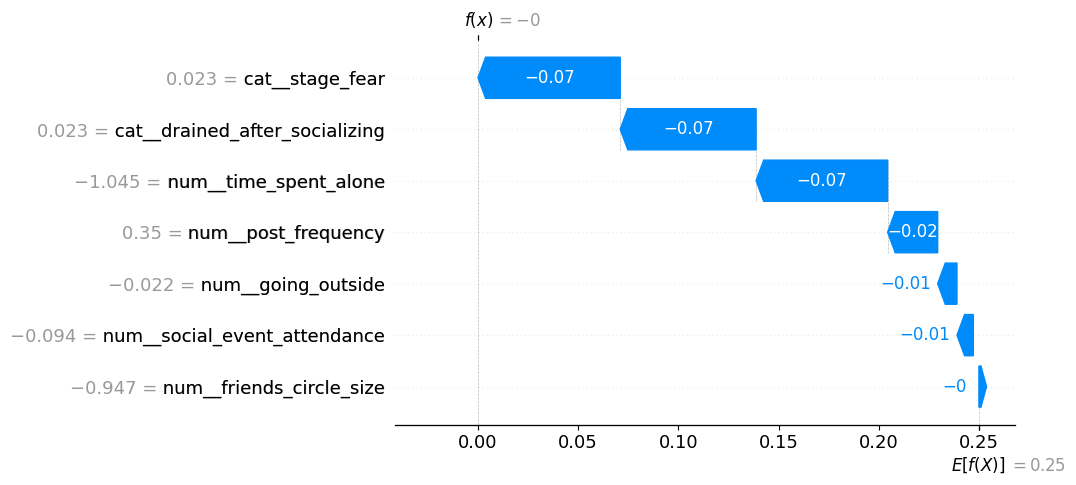

In [187]:
i = 1
shap.plots.waterfall(shap_values_tree[i], max_display=14)

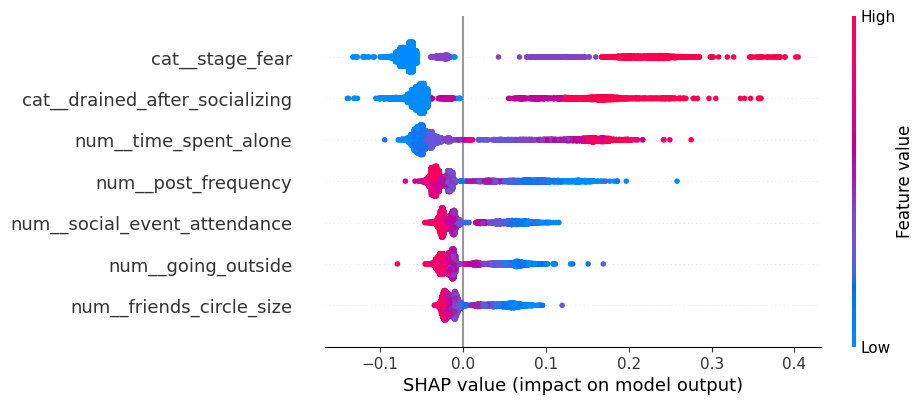

In [188]:
shap.plots.beeswarm(shap_values_tree)

# <font color='blue'> **Сохранение модели**

In [189]:
import pickle

# Сохранение пайплайна в файл
with open('pipeline_best_model.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f)

print("Pipeline сохранен в файл 'pipeline_best_model.pkl'.")


Pipeline сохранен в файл 'pipeline_best_model.pkl'.


# <font color='blue'> **Инференс модели**

In [190]:
# Загрузка пайплайна из файла
with open('pipeline_best_model.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

print("Pipeline загружен.")


Pipeline загружен.


In [191]:
loaded_pipeline.steps[1][1]#.get_feature_names_out()

RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=99,
                       random_state=47)

In [192]:
df_test['pred'] = loaded_pipeline.predict(df_test)

In [193]:
df_test

,id,time_spent_alone,stage_fear,social_event_attendance,going_outside,drained_after_socializing,friends_circle_size,post_frequency,pred
0,18524,3.0,No,7.0,4.0,No,6.0,NaN,0
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0,1
2,18526,3.0,No,5.0,6.0,No,15.0,9.0,0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0,0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...
6170,24694,3.0,No,5.0,5.0,No,9.0,6.0,0
6171,24695,8.0,Yes,2.0,1.0,Yes,0.0,0.0,1
6172,24696,2.0,No,4.0,3.0,No,9.0,7.0,0
6173,24697,3.0,No,4.0,4.0,No,11.0,9.0,0


In [194]:
#dict_personality = {'Extrovert':0, 'Introvert':1}
dict_personality_rev = {0:'Extrovert', 1:'Introvert'}

In [195]:
df_test['Personality'] = df_test['pred'].map(dict_personality_rev)

In [196]:
df_test

,id,time_spent_alone,stage_fear,social_event_attendance,going_outside,drained_after_socializing,friends_circle_size,post_frequency,pred,Personality
0,18524,3.0,No,7.0,4.0,No,6.0,NaN,0,Extrovert
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0,1,Introvert
2,18526,3.0,No,5.0,6.0,No,15.0,9.0,0,Extrovert
3,18527,3.0,No,4.0,4.0,No,5.0,6.0,0,Extrovert
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0,1,Introvert
...,...,...,...,...,...,...,...,...,...,...
6170,24694,3.0,No,5.0,5.0,No,9.0,6.0,0,Extrovert
6171,24695,8.0,Yes,2.0,1.0,Yes,0.0,0.0,1,Introvert
6172,24696,2.0,No,4.0,3.0,No,9.0,7.0,0,Extrovert
6173,24697,3.0,No,4.0,4.0,No,11.0,9.0,0,Extrovert


In [197]:
df_test[['id', 'Personality']].to_csv('submission.csv', index=False)

In [198]:
!kaggle competitions submit -c playground-series-s5e7 -f submission.csv -m "1 commit"

100%|███████████████████████████████████████| 96.5k/96.5k [00:00<00:00, 116kB/s]
Successfully submitted to Predict the Introverts from the Extroverts